In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import feedparser as fp

%matplotlib inline

## 4.5 使用Python 进行文本分类

### 4.5.1 准备数据：从文本中构建词向量

In [2]:
def load_dataset():
    posting_list = [['my', 'dog', 'has', 'flea', 'problems', 'help', 'please'],
                    ['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid'],
                    ['my', 'dalmation', 'is', 'so', 'cute', 'I', 'love', 'him'], 
                    ['stop', 'posting', 'stupid', 'worthless', 'garbage'], 
                    ['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him'], 
                    ['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']]
    class_vec = [0, 1, 0, 1, 0, 1]
    return posting_list, class_vec

In [3]:
def create_vocab_list(dataset):   # 词汇表
    vocab_set = set()
    for document in dataset:
        vocab_set = vocab_set | set(document)
    return list(vocab_set)

def set_of_words_2_vec(vocab_list, input_set):  # 长度为词汇表大小的词向量
    return_vec = [0] * len(vocab_list)
    for word in input_set:
        if word in vocab_list:
            return_vec[vocab_list.index(word)] = 1
        else:
            print('The word: %s is not in my vocabulary!' % word)
    return return_vec

In [4]:
list_posts, list_classes = load_dataset()
vocab_list = create_vocab_list(list_posts)
print(vocab_list)

['I', 'has', 'so', 'posting', 'to', 'him', 'stupid', 'worthless', 'licks', 'not', 'love', 'stop', 'dalmation', 'flea', 'please', 'dog', 'food', 'steak', 'take', 'is', 'help', 'my', 'problems', 'quit', 'ate', 'garbage', 'mr', 'maybe', 'how', 'buying', 'cute', 'park']


### 4.5.2 训练算法：从词向量计算概率

/Users/gaussic/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


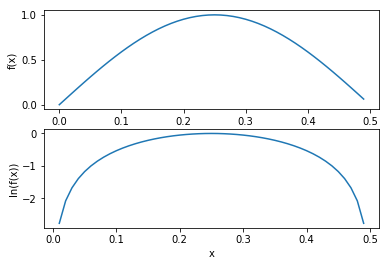

In [5]:
t = np.arange(0.0, 0.5, 0.01)
s = np.sin(2*np.pi*t)
logS = np.log(s)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t,s)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')

ax = fig.add_subplot(212)
ax.plot(t,logS)
ax.set_ylabel('ln(f(x))')
ax.set_xlabel('x')
plt.show()

### 4.5.3 测试算法：根据现实情况修改分类器

In [6]:
def train_nbo(train_matrix, train_category):
    '''每个类别中，每个词出现的概率'''
    num_train_docs = len(train_matrix)
    num_words = len(train_matrix[0])
    p_abusive = np.sum(train_category) / float(num_train_docs) # 1出现的概率
    p0_num = np.ones((num_words))       # 该类别中，每个词出现多少次，防止为0，全部初始化为1
    p1_num = np.ones((num_words))
    for i in range(num_train_docs):
        if train_category[i] == 1:
            p1_num += train_matrix[i]
        else:
            p0_num += train_matrix[i]
    p1_vect = np.log(p1_num / np.sum(p1_num))  # 采用 log
    p0_vect = np.log(p0_num / np.sum(p0_num))
    return p0_vect, p1_vect, p_abusive

In [7]:
train_mat = []
for posting_doc in list_posts:
    train_mat.append(set_of_words_2_vec(vocab_list, posting_doc))
p0v, p1v, pab = train_nbo(train_mat, list_classes)
p0v

array([-3.33220451, -3.33220451, -3.33220451, -4.02535169, -3.33220451,
       -2.9267394 , -4.02535169, -4.02535169, -3.33220451, -4.02535169,
       -3.33220451, -3.33220451, -3.33220451, -3.33220451, -3.33220451,
       -3.33220451, -4.02535169, -3.33220451, -4.02535169, -3.33220451,
       -3.33220451, -2.63905733, -3.33220451, -4.02535169, -3.33220451,
       -4.02535169, -3.33220451, -4.02535169, -3.33220451, -4.02535169,
       -3.33220451, -4.02535169])

In [8]:
def classify_nb(vec_2_classify, p0_vec, p1_vec, p_class1):
    p1 = np.sum(vec_2_classify * p1_vec) + np.log(p_class1)
    p0 = np.sum(vec_2_classify * p0_vec) + np.log(1 - p_class1)
    if p1 > p0:
        return 1
    else:
        return 0

def testing_nb():
    list_posts, list_classes = load_dataset()
    vocab_list = create_vocab_list(list_posts)
    train_mat = [set_of_words_2_vec(vocab_list, posting_doc) for posting_doc in list_posts]
    p01, p1v, p_class1 = train_nbo(np.array(train_mat), np.array(list_classes))
    test_entry = ['love', 'my', 'dalmation']
    this_doc = np.array(set_of_words_2_vec(vocab_list, test_entry))
    print(test_entry, 'classified as:', classify_nb(this_doc, p0v, p1v, p_class1))
    test_entry = ['stupid', 'garbage']
    this_doc = np.array(set_of_words_2_vec(vocab_list, test_entry))
    print(test_entry, 'classified as:', classify_nb(this_doc, p0v, p1v, p_class1))
    

In [9]:
testing_nb()

['love', 'my', 'dalmation'] classified as: 0
['stupid', 'garbage'] classified as: 1


### 4.5.4 准备数据：文档词袋模型

In [10]:
def bag_of_words_2_vec(vocab_list, input_set):
    return_vec = [0] * len(vocab_list)
    for word in input_set:
        if word in vocab_list:
            return_vec[vocab_list.index(word)] += 1
    return return_vec

## 4.6 示例：使用朴素贝叶斯过滤垃圾邮件

### 4.6.1 准备数据：切分文本

### 4.6.2 测试算法：使用朴素贝叶斯进行交叉验证

In [11]:
def text_parse(big_string):
    list_of_tokens = re.split(r'\W+', big_string)
    return [tok.lower() for tok in list_of_tokens if len(tok) > 2]

def spam_test():
    doc_list = []
    class_list = []
    full_text = []
    for i in range(1, 26):
        word_list = text_parse(open('email/spam/%d.txt' % i, encoding='utf-8').read())
        
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(1)
        word_list = text_parse(open('email/ham/%d.txt' % i, encoding='utf-8').read())
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(0)
    vocab_list = create_vocab_list(doc_list)
    training_set = list(range(50))
    test_set = []
    for i in range(10):
        rand_index = int(np.random.uniform(0, len(training_set)))
        test_set.append(training_set[rand_index])
        del[training_set[rand_index]]
    train_mat = []
    train_class = []
    for doc_index in training_set:
        train_mat.append(bag_of_words_2_vec(vocab_list, doc_list[doc_index]))
        train_class.append(class_list[doc_index])
    p0v, p1v, pSpam = train_nbo(np.array(train_mat), np.array(train_class))
    
    error_count = 0
    for doc_index in test_set:
        word_vector = bag_of_words_2_vec(vocab_list, doc_list[doc_index])
        if classify_nb(np.array(word_vector), p0v, p1v, pSpam) != class_list[doc_index]:
            error_count += 1
    print("The erro rate is: %f" % (float(error_count) / len(test_set)))

In [12]:
spam_test()

The erro rate is: 0.000000


## 4.7 使用朴素贝叶斯分类器从个人广告中获取区域倾向

In [13]:
def calc_most_freq(vocab_list, full_text):
    freq_dict = {}
    for token in vocab_list:
        freq_dict[token] = full_text.count(token)
        sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_freq[:30]

def local_words(feed1, feed0):
    doc_list = []
    class_list = []
    full_text = []
    min_len = min(len(feed1['entries']), len(feed0['entries']))
    for i in range(min_len):
        word_list = text_parse(feed1['entries'][i]['summary'])
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(1)
        word_list = text_parse(feed0['entries'][i]['summary'])
        doc_list.append(word_list)
        full_text.extend(word_list)
        class_list.append(0)
    vocab_list = create_vocab_list(doc_list)
    top30_words = calc_most_freq(vocab_list, full_text)
    for pairW in top30_words:
        if pairW[0] in vocab_list:
            vocab_list.remove(pairW[0])
    training_set = list(range(2*min_len));
    test_set = []
    for i in range(10):
        rand_index = int(np.random.uniform(0, len(training_set)))
        test_set.append(training_set[rand_index])
        del[training_set[rand_index]]
    train_mat = []
    train_classes = []
    for doc_index in training_set:
        train_mat.append(bag_of_words_2_vec(vocab_list, doc_list[doc_index]))
        train_classes.append(class_list[doc_index])
    p0v, p1v, pSpam = train_nbo(np.array(train_mat), np.array(train_classes))
    error_count = 0
    
    for doc_index in test_set:
        word_vector = bag_of_words_2_vec(vocab_list, doc_list[doc_index])
        if classify_nb(np.array(word_vector), p0v, p1v, pSpam) != class_list[doc_index]:
            error_count += 1
    print("The erro rate is: %f" % (float(error_count) / len(test_set)))
    return vocab_list, p0v, p1v

In [14]:
ny = fp.parse('http://newyork.craigslist.org/stp/index.rss')
sf = fp.parse('http://sfbay.craigslist.org/stp/index.rss')

In [15]:
vocab_list, psf, pny = local_words(ny, sf)

The erro rate is: 0.400000


### 4.7.2 分析数据：显示地域相关的用词

In [16]:
def get_top_words(ny, sf):
    vocab_list, p0v, p1v = local_words(ny, sf)
    top_ny = []
    top_sf = []
    for i in range(len(p0v)):
        if p0v[i] > -6.0:
            top_sf.append((vocab_list[i], p0v[i]))
        if p1v[i] > -6.0:
            top_ny.append((vocab_list[i], p1v[i]))
    sorted_sf = sorted(top_sf, key=lambda x : x[1], reverse=True)
    print('SF**'*10)
    for item in sorted_sf:
        print(item[0])
    sorted_ny = sorted(top_ny, key=lambda x : x[1], reverse=True)
    print('NY**'*10)
    for item in sorted_ny:
        print(item[0])

In [17]:
get_top_words(ny, sf)

The erro rate is: 0.300000
SF**SF**SF**SF**SF**SF**SF**SF**SF**SF**
friend
going
through
fun
partner
from
talk
only
around
new
right
find
well
professional
jose
there
age
people
group
also
times
trying
more
san
salsa
would
friends
female
ongoing
weekend
play
greetings
cool
cha
facebook
sunnyvale
local
maybe
country
few
must
drinks
lot
join
over
western
lupin
serious
part
event
straight
dances
drink
created
healthy
dancer
now
road
white
each
take
hikers
grab
bodyfest
top
other
been
long
latin
knows
tennis
anymore
kindred
then
meet
better
dance
woman
2017
likes
steady
married
living
NY**NY**NY**NY**NY**NY**NY**NY**NY**NY**
let
any
need
get
meet
new
person
tantra
them
here
into
over
feet
woman
after
briefs
etc
single
there
male
maybe
thoughts
reach
look
day
job
email
connect
school
from
will
women
being
now
year
very
work
massage
upscale
free
next
friend
posting
anything
life
see
wanted
could
friends
